In [1]:
import numpy as np
from pathlib import Path
import struct
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import time

In [2]:
dataset_path = Path("./MNIST")
train_img_path = dataset_path/'train-images-idx3-ubyte'
train_lab_path = dataset_path/'train-labels-idx1-ubyte'
test_img_path = dataset_path/'t10k-images-idx3-ubyte'
test_lab_path = dataset_path/'t10k-labels-idx1-ubyte'

with open(train_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    tmp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
    train_img = tmp_img[:]
with open(test_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(train_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    tmp_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
    train_lab = tmp_lab[:]
with open(test_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)

# len(train_img)
# FUNCTION: show_image(index)
def show_image(img, index):
    plt.imshow(img[index].reshape(28, 28), cmap='gray')
    plt.pause(1)
    # print("label: {}".format(label[index]))
    return 0
# show_image(train_img, train_lab, 30)
# len(train_lab[np.where(train_lab == 9)])

# train_num = train_img.shape[0]
# test_num = test_img.shape[0]
# print(train_img.shape)
# print(test_img.shape)
# print(train_lab.shape)

In [3]:
# 将给定num的label改为1
def train_setY(num):
    label = train_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label
def test_setY(num):
    label = test_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label

In [9]:
# 激活函数
def sigmoid(x):
    y = 1.0 / (1.0 + np.exp(-1.0*x))
    return y

# 参数初始化
def initialize_params(dim):
    # 初始化在 -1~1 范围内
    # np.random.seed(6)
    # w = -1 + 2*np.random.random((dim, 1))
    
    # 初始化为全0矩阵
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

# 向前传播
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1.0/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    dw = (1.0/m) * np.dot(X, (A-Y).T)
    db = (1.0/m) * np.sum(A-Y)

    Y_prediction = np.zeros((1, m))
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    accu = 100 - np.mean(np.abs(Y_prediction-Y)) * 100

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {
        "dw": dw,
        "db": db
    }

    return grads, cost, accu

# 参数优化
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    accus = []

    for i in tqdm(range(num_iterations)):
        grads, cost, accu = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        # if i%10 == 0:
        #     costs.append(cost)
        #     accus.append(accu)
        costs.append(cost)
        accus.append(accu)

        if print_cost and i%100 == 0:
            print("After iterations %i:" %i, end=" ")
            print(" Cost: %f" %cost, end=" ")
            print(" Accu: %f" %accu, end="\n")

    params = {
        "w": w,
        "b": b
    }
    grads = {
        "dw": dw,
        "db": db
    }
    return params, grads, accus, costs

# 模型预测
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    assert(Y_prediction.shape == (1, m))

    return Y_prediction

# 模型建立
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    w, b = initialize_params(X_train.shape[0])
    # parameters, grads, costs= optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    parameters, grads, accus, costs= optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_train-Y_train))*100))
    print("test accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_test-Y_test))*100))
    
    d = {
        "w": w,
        "b": b,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations,
        "accus": accus,
        "costs": costs
    }
    
    return d
    

In [10]:
# 指定训练目标数字
def reg_num_set(reg_num):
    # reg_num = 6
    train_X = train_img.copy().T
    train_Y = train_setY(reg_num).T
    index_regnum = np.where(train_Y==1)
    # print(index_regnum)
    
    test_X = test_img.copy().T
    test_Y = test_setY(reg_num).T
    # print(f"train set shape: {train_X.shape}")
    # print(f"train lab shape: {train_Y.shape}")
    # print(f"test set shape: {test_X.shape}")
    # print(f"test lab shape: {test_Y.shape}")

    # 展示选取的训练数字的原图片
    # show_image(train_X.T, 1)
    # hw0 = train_X.T
    # i = index_regnum[1][0]
    # np.save(f'handwritten{reg_num}.npy', hw0[i])
    # plt.imshow(hw0[i].reshape((28,28)))
    # plt.axis('off')

    # # print(train_Y[30])
    # print(train_Y.shape)
    # # print(np.where(train_Y==1))
    # tmp = train_lab.copy().T[:, :limit_train]
    # len(tmp[np.where(tmp == reg_num)])

    return reg_num, train_X, train_Y, test_X, test_Y

In [ ]:
reg_num, train_X, train_Y, test_X, test_Y = reg_num_set(0)
print(f"Number {reg_num} Recognition:")
d = model(train_X, train_Y, test_X, test_Y, num_iterations=1000, learning_rate=0.05, print_cost=True)

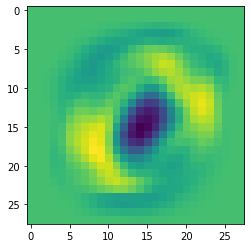

[0.17563774]
[-0.41741197]


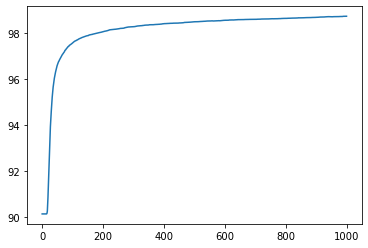

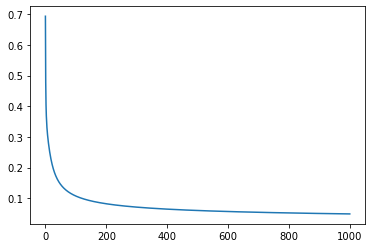

In [40]:
w = d['w'].copy()
plt.imshow(w.reshape((28,28)))
plt.pause(0.1)
print(max(w))
print(min(w))

accus = d['accus'].copy()
plt.plot(accus)
plt.show()

costs = d['costs'].copy()
plt.plot(costs)
plt.show()

Number 0 Recognition:


100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s]


train accuracy: 98.73666666666666%
test accuracy: 98.99%

Number 1 Recognition:


100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


train accuracy: 98.73%
test accuracy: 98.95%

Number 2 Recognition:


100%|██████████| 1000/1000 [01:11<00:00, 13.95it/s]


train accuracy: 97.16833333333334%
test accuracy: 97.42%

Number 3 Recognition:


100%|██████████| 1000/1000 [01:14<00:00, 13.42it/s]


train accuracy: 96.64833333333334%
test accuracy: 96.98%

Number 4 Recognition:


100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]


train accuracy: 97.625%
test accuracy: 97.49%

Number 5 Recognition:


100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


train accuracy: 95.89833333333334%
test accuracy: 96.19%

Number 6 Recognition:


100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


train accuracy: 98.24333333333334%
test accuracy: 98.11%

Number 7 Recognition:


100%|██████████| 1000/1000 [01:11<00:00, 13.94it/s]


train accuracy: 97.99166666666666%
test accuracy: 98.08%

Number 8 Recognition:


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


train accuracy: 94.69166666666666%
test accuracy: 94.53%

Number 9 Recognition:


100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


train accuracy: 95.42166666666667%
test accuracy: 95.72%



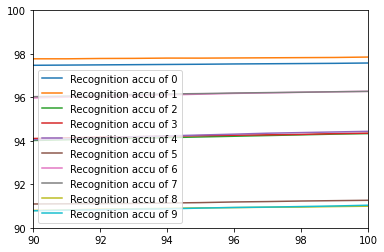

In [11]:
regnum_accu = {}
regnum_cost = {}
regnum_w = {}
for each in range(10):
    reg_num, train_X, train_Y, test_X, test_Y = reg_num_set(each)
    # 进行模型训练
    print(f"Number {reg_num} Recognition:")
    d = model(train_X, train_Y, test_X, test_Y, num_iterations=1000, learning_rate=0.05, print_cost=False)
    regnum_accu[each] = d["accus"]
    regnum_cost[each] = d["costs"]
    regnum_w[each] = d["w"]
    print()
for i in range(10):
    plt.plot(regnum_accu[i], label=f"Recognition accu of {i}")
plt.xlim(0, 1000)
plt.ylim(90, 100)
plt.legend(loc=3)
plt.show()

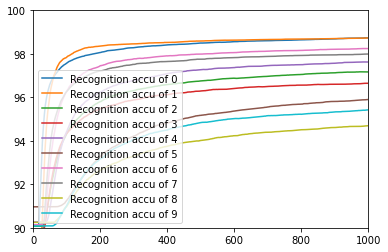

In [12]:
for i in range(10):
    plt.plot(regnum_accu[i], label=f"Recognition accu of {i}")
plt.xlim(0, 1000)
plt.ylim(90, 100)
plt.legend(loc=3)
plt.show()